## Fit go/no-go using the chi-qsuare approach
### by Jan Willem de Gee (jwdegee@gmail.com)

This is a demo of fitting go/no-go data with HDDM using the chi-qsuare method, as described in 

    de Gee JW, Tsetsos T, McCormick DA, McGinley MJ & Donner TH. 2018. Phasic arousal optimizes decision computations in mice and humans. bioRxiv. (https://www.biorxiv.org/content/early/2018/10/19/447656).
    

See also
    
    Ratcliff, R., Huang-Pollock, C., & McKoon, G. (2016). Modeling individual differences in the go/no-go task with a diffusion model. Decision, 5(1), 42-62 (http://psycnet.apa.org/record/2016-39470-001).

In [18]:
# Load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hddm
from joblib import Parallel, delayed

Let's start with defining some functionality

In [17]:
def get_choice(row):
    if row.condition == "present":
        if row.response == 1:
            return 1
        else:
            return 0
    elif row.condition == "absent":
        if row.response == 0:
            return 1
        else:
            return 0


def simulate_data(
    a, v, t, z, dc, sv=0, sz=0, st=0, condition=0, nr_trials1=1000, nr_trials2=1000
):
    """
    Simulates stim-coded data.
    """

    parameters1 = {"a": a, "v": v + dc, "t": t, "z": z, "sv": sv, "sz": sz, "st": st}
    parameters2 = {
        "a": a,
        "v": v - dc,
        "t": t,
        "z": 1 - z,
        "sv": sv,
        "sz": sz,
        "st": st,
    }
    df_sim1, params_sim1 = hddm.generate.gen_rand_data(
        params=parameters1, size=nr_trials1, subjs=1, subj_noise=0
    )
    df_sim1["condition"] = "present"
    df_sim2, params_sim2 = hddm.generate.gen_rand_data(
        params=parameters2, size=nr_trials2, subjs=1, subj_noise=0
    )
    df_sim2["condition"] = "absent"
    df_sim = pd.concat((df_sim1, df_sim2))
    df_sim["bias_response"] = df_sim.apply(get_choice, 1)
    df_sim["correct"] = df_sim["response"].astype(int)
    df_sim["response"] = df_sim["bias_response"].astype(int)
    df_sim["stimulus"] = np.array(
        (np.array(df_sim["response"] == 1) & np.array(df_sim["correct"] == 1))
        + (np.array(df_sim["response"] == 0) & np.array(df_sim["correct"] == 0)),
        dtype=int,
    )
    df_sim["condition"] = condition
    df_sim = df_sim.drop(columns=["bias_response"])

    return df_sim


def fit_subject(data, quantiles):
    """
    Simulates stim-coded data.
    """

    subj_idx = np.unique(data["subj_idx"])
    m = hddm.HDDMStimCoding(
        data,
        stim_col="stimulus",
        split_param="v",
        drift_criterion=True,
        bias=True,
        p_outlier=0,
        depends_on={
            "v": "condition",
            "a": "condition",
            "t": "condition",
            "z": "condition",
            "dc": "condition",
        },
    )
    m.optimize("gsquare", quantiles=quantiles, n_runs=8)
    res = pd.concat(
        (
            pd.DataFrame([m.values], index=[subj_idx]),
            pd.DataFrame([m.bic_info], index=[subj_idx]),
        ),
        axis=1,
    )
    return res


def summary_plot(
    df_group,
    df_sim_group=None,
    quantiles=[
        0,
        0.1,
        0.3,
        0.5,
        0.7,
        0.9,
    ],
    xlim=None,
):
    """
    Generates a
    """

    nr_subjects = len(np.unique(df_group["subj_idx"]))

    fig = plt.figure(figsize=(10, nr_subjects * 2))
    plt_nr = 1
    for s in np.unique(df_group["subj_idx"]):
        df = df_group.copy().loc[(df_group["subj_idx"] == s), :]
        df_sim = df_sim_group.copy().loc[(df_sim_group["subj_idx"] == s), :]
        df["rt_acc"] = df["rt"].copy()
        df.loc[df["correct"] == 0, "rt_acc"] = df.loc[df["correct"] == 0, "rt_acc"] * -1
        df["rt_resp"] = df["rt"].copy()
        df.loc[df["response"] == 0, "rt_resp"] = (
            df.loc[df["response"] == 0, "rt_resp"] * -1
        )
        df_sim["rt_acc"] = df_sim["rt"].copy()
        df_sim.loc[df_sim["correct"] == 0, "rt_acc"] = (
            df_sim.loc[df_sim["correct"] == 0, "rt_acc"] * -1
        )
        df_sim["rt_resp"] = df_sim["rt"].copy()
        df_sim.loc[df_sim["response"] == 0, "rt_resp"] = (
            df_sim.loc[df_sim["response"] == 0, "rt_resp"] * -1
        )
        max_rt = np.percentile(df_sim.loc[~np.isnan(df_sim["rt"]), "rt"], 99)
        bins = np.linspace(-max_rt, max_rt, 30)
        # rt distributions correct vs error:
        ax = fig.add_subplot(nr_subjects, 4, plt_nr)
        N, bins, patches = ax.hist(
            df.loc[:, "rt_acc"], bins=bins, density=True, color="green", alpha=0.5
        )

        for bin_size, bin, patch in zip(N, bins, patches):
            if bin < 0:
                plt.setp(patch, "facecolor", "r")
        if df_sim is not None:
            ax.hist(
                df_sim.loc[:, "rt_acc"],
                bins=bins,
                density=True,
                histtype="step",
                color="k",
                alpha=1,
                label=None,
            )
        ax.set_title(
            "P(correct)={}".format(
                round(df.loc[:, "correct"].mean(), 3),
            )
        )
        ax.set_xlabel("RT (s)")
        ax.set_ylabel("Trials (prob. dens.)")
        plt_nr += 1

        # condition accuracy plots:
        ax = fig.add_subplot(nr_subjects, 4, plt_nr)
        df.loc[:, "rt_bin"] = pd.qcut(df["rt"], quantiles, labels=False)
        d = df.groupby(["rt_bin"]).mean().reset_index()
        ax.errorbar(
            d.loc[:, "rt"], d.loc[:, "correct"], fmt="-o", color="orange", markersize=10
        )
        if df_sim is not None:
            df_sim.loc[:, "rt_bin"] = pd.qcut(df_sim["rt"], quantiles, labels=False)
            d = df_sim.groupby(["rt_bin"]).mean().reset_index()
            ax.errorbar(
                d.loc[:, "rt"], d.loc[:, "correct"], fmt="x", color="k", markersize=6
            )
        if xlim:
            ax.set_xlim(xlim)
        ax.set_ylim(0, 1.25)
        ax.set_title("Conditional accuracy")
        ax.set_xlabel("RT (quantiles)")
        ax.set_ylabel("P(correct)")
        plt_nr += 1

        # rt distributions response 1 vs 0:
        ax = fig.add_subplot(nr_subjects, 4, plt_nr)
        if np.isnan(df["rt"]).sum() > 0:
            # some initial computations
            bar_width = 1
            fraction_yes = df["response"].mean()
            fraction_yes_sim = df_sim["response"].mean()
            no_height = (1 - fraction_yes) / bar_width
            no_height_sim = (1 - fraction_yes_sim) / bar_width

            hist, edges = np.histogram(
                df.loc[:, "rt_resp"],
                bins=bins,
                density=True,
            )
            hist = hist * fraction_yes
            hist_sim, edges_sim = np.histogram(
                df_sim.loc[:, "rt_resp"],
                bins=bins,
                density=True,
            )
            hist_sim = hist_sim * fraction_yes_sim

            # Add histogram from go choices
            # ground truth
            ax.bar(
                edges[:-1],
                hist,
                width=np.diff(edges)[0],
                align="edge",
                color="magenta",
                alpha=0.5,
                linewidth=0,
            )
            # simulations
            ax.step(edges_sim[:-1] + np.diff(edges)[0], hist_sim, color="black", lw=1)

            # Add bar for the no-go choices (on the negative rt scale)
            # This just illustrates the probability of no-go choices

            # ground truth
            ax.bar(
                x=-1.5,
                height=no_height,
                width=bar_width,
                alpha=0.5,
                color="cyan",
                align="center",
            )

            # simulations
            ax.hlines(
                y=no_height_sim,
                xmin=-2,
                xmax=-1,
                lw=0.5,
                colors="black",
            )
            ax.vlines(x=-2, ymin=0, ymax=no_height_sim, lw=0.5, colors="black")
            ax.vlines(x=-1, ymin=0, ymax=no_height_sim, lw=0.5, colors="black")
        else:
            N, bins, patches = ax.hist(
                df.loc[:, "rt_resp"],
                bins=bins,
                density=True,
                color="magenta",
                alpha=0.5,
            )
            for bin_size, bin, patch in zip(N, bins, patches):
                if bin < 0:
                    plt.setp(patch, "facecolor", "cyan")
            ax.hist(
                df_sim.loc[:, "rt_resp"],
                bins=bins,
                density=True,
                histtype="step",
                color="k",
                alpha=1,
                label=None,
            )

        ax.set_title(
            "P(bias)={}".format(
                round(df.loc[:, "response"].mean(), 3),
            )
        )
        ax.set_xlabel("RT (s)")
        ax.set_ylabel("Trials (prob. dens.)")
        plt_nr += 1

        # condition response plots:
        ax = fig.add_subplot(nr_subjects, 4, plt_nr)
        df.loc[:, "rt_bin"] = pd.qcut(df["rt"], quantiles, labels=False)
        d = df.groupby(["rt_bin"]).mean().reset_index()
        ax.errorbar(
            d.loc[:, "rt"],
            d.loc[:, "response"],
            fmt="-o",
            color="orange",
            markersize=10,
        )
        if df_sim is not None:
            df_sim.loc[:, "rt_bin"] = pd.qcut(df_sim["rt"], quantiles, labels=False)
            d = df_sim.groupby(["rt_bin"]).mean().reset_index()
            ax.errorbar(
                d.loc[:, "rt"], d.loc[:, "response"], fmt="x", color="k", markersize=6
            )
        if xlim:
            ax.set_xlim(xlim)
        ax.set_ylim(0, 1.25)
        ax.set_title("Conditional response")
        ax.set_xlabel("RT (quantiles)")
        ax.set_ylabel("P(bias)")
        plt_nr += 1

    sns.despine(offset=3, trim=True)
    plt.tight_layout()

    return fig

Let's simulate our own data, so we know what the fitting procedure should converge on:

In [3]:
# settings
go_nogo = True  # should we put all RTs for one choice alternative to NaN (go-no data)?
n_subjects = 4
trials_per_level = 10000

# parameters:
params0 = {
    "cond": 0,
    "v": 0.5,
    "a": 2.0,
    "t": 0.3,
    "z": 0.5,
    "dc": -0.2,
    "sz": 0,
    "st": 0,
    "sv": 0,
}
params1 = {
    "cond": 1,
    "v": 0.5,
    "a": 2.0,
    "t": 0.3,
    "z": 0.5,
    "dc": 0.2,
    "sz": 0,
    "st": 0,
    "sv": 0,
}

# simulate:
dfs = []
for i in range(n_subjects):
    df0 = simulate_data(
        z=params0["z"],
        a=params0["a"],
        v=params0["v"],
        dc=params0["dc"],
        t=params0["t"],
        sv=params0["sv"],
        st=params0["st"],
        sz=params0["sz"],
        condition=params0["cond"],
        nr_trials1=trials_per_level,
        nr_trials2=trials_per_level,
    )
    df1 = simulate_data(
        z=params1["z"],
        a=params1["a"],
        v=params1["v"],
        dc=params1["dc"],
        t=params1["t"],
        sv=params1["sv"],
        st=params1["st"],
        sz=params1["sz"],
        condition=params1["cond"],
        nr_trials1=trials_per_level,
        nr_trials2=trials_per_level,
    )
    df = pd.concat((df0, df1))
    df["subj_idx"] = i
    dfs.append(df)

# combine in one dataframe:
df_emp = pd.concat(dfs)
if go_nogo:
    df_emp.loc[df_emp["response"] == 0, "rt"] = np.NaN

In [4]:
df_emp

,rt,response,subj_idx,condition,correct,stimulus
0,0.880,1,0,0,1,1
1,NaN,0,0,0,0,1
2,1.499,1,0,0,1,1
3,NaN,0,0,0,0,1
4,NaN,0,0,0,0,1
...,...,...,...,...,...,...
9995,0.829,1,3,1,0,0
9996,0.938,1,3,1,0,0
9997,1.674,1,3,1,0,0
9998,NaN,0,3,1,1,0


Fit using the g-quare method.

In [5]:
# fit chi-square:
quantiles = [0.1, 0.3, 0.5, 0.7, 0.9]
params_fitted = pd.concat(
    Parallel(n_jobs=n_subjects)(
        delayed(fit_subject)(data[1], quantiles) for data in df_emp.groupby("subj_idx")
    )
)

In [6]:
params_fitted.drop(
    ["bic", "likelihood", "penalty", "z_trans(0)", "z_trans(1)"], axis=1, inplace=True
)
print(params_fitted)

       a(0)      a(1)      v(0)      v(1)      t(0)      t(1)      z(0)  \
0  1.957684  1.997512  0.506885  0.503210  0.291217  0.304618  0.476925   
1  1.992596  2.009814  0.495720  0.514267  0.286401  0.271875  0.481426   
2  1.971131  1.996191  0.522817  0.495448  0.270259  0.283106  0.451006   
3  1.999619  1.972885  0.501150  0.493823  0.309258  0.298655  0.512594   

       z(1)     dc(0)     dc(1)  
0  0.503880 -0.157141  0.197714  
1  0.470882 -0.158436  0.259854  
2  0.478944 -0.096833  0.231788  
3  0.489152 -0.223152  0.236227  


In [7]:
# simulate data based on fitted params:
dfs = []
for i in range(n_subjects):
    df0 = simulate_data(
        a=params_fitted.loc[i, "a(0)"],
        v=params_fitted.loc[i, "v(0)"],
        t=params_fitted.loc[i, "t(0)"],
        z=params_fitted.loc[i, "z(0)"],
        dc=params_fitted.loc[i, "dc(0)"],
        condition=0,
        nr_trials1=trials_per_level,
        nr_trials2=trials_per_level,
    )
    df1 = simulate_data(
        a=params_fitted.loc[i, "a(1)"],
        v=params_fitted.loc[i, "v(1)"],
        t=params_fitted.loc[i, "t(1)"],
        z=params_fitted.loc[i, "z(1)"],
        dc=params_fitted.loc[i, "dc(1)"],
        condition=1,
        nr_trials1=trials_per_level,
        nr_trials2=trials_per_level,
    )
    df = pd.concat((df0, df1))
    df["subj_idx"] = i
    dfs.append(df)
df_sim = pd.concat(dfs)
if go_nogo:
    df_sim.loc[df_sim["response"] == 0, "rt"] = np.NaN

In [8]:
df_sim

,rt,response,subj_idx,condition,correct,stimulus
0,1.668217,1,0,0,1,1
1,1.870217,1,0,0,1,1
2,3.025217,1,0,0,1,1
3,0.914217,1,0,0,1,1
4,1.033217,1,0,0,1,1
...,...,...,...,...,...,...
9995,NaN,0,3,1,1,0
9996,NaN,0,3,1,1,0
9997,NaN,0,3,1,1,0
9998,0.676655,1,3,1,0,0


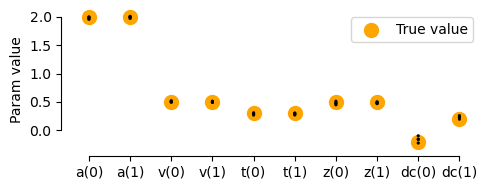

In [19]:
# Plot true vs recovered parameters:
x = np.arange(5) * 2
y0 = np.array([params0["a"], params0["v"], params0["t"], params0["z"], params0["dc"]])
y1 = np.array([params1["a"], params1["v"], params1["t"], params1["z"], params1["dc"]])
fig = plt.figure(figsize=(5, 2))
ax = fig.add_subplot(111)
ax.scatter(x, y0, marker="o", s=100, color="orange", label="True value")
ax.scatter(
    x + 1,
    y1,
    marker="o",
    s=100,
    color="orange",
)
sns.stripplot(
    data=params_fitted,
    jitter=False,
    size=2,
    edgecolor="black",
    linewidth=0.25,
    alpha=1,
    palette=["black", "black"],
    ax=ax,
)
plt.ylabel("Param value")
plt.legend()
sns.despine(
    offset=5,
    trim=True,
)
plt.tight_layout()
plt.show()

CONDITION 0


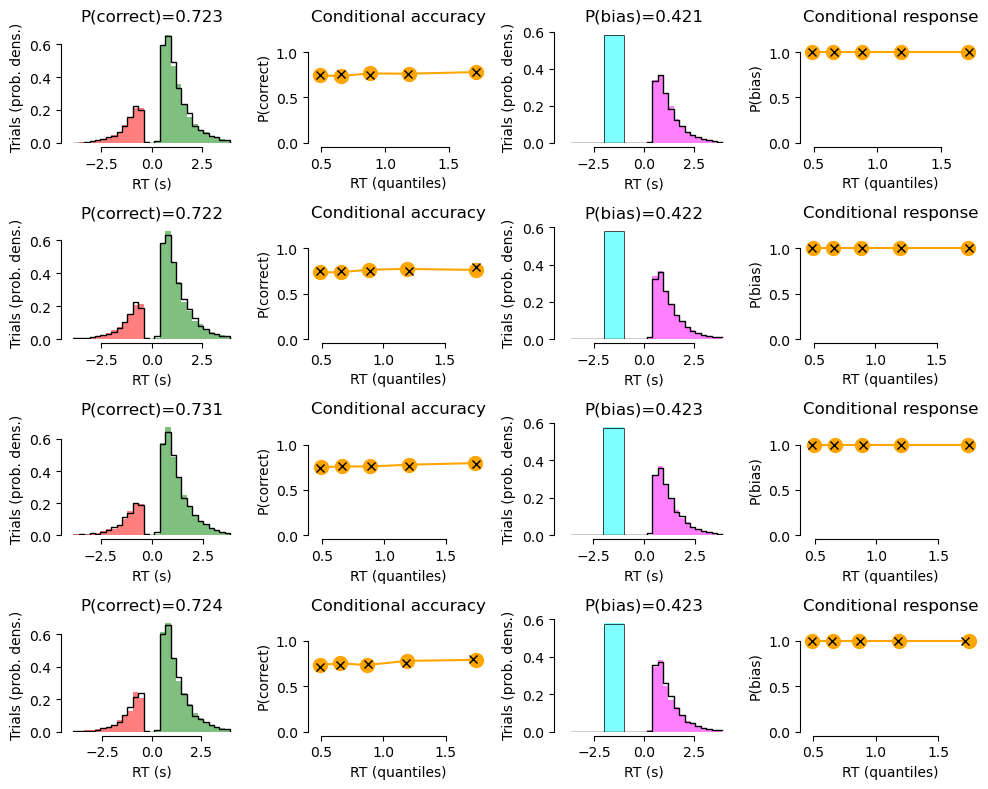

CONDITION 1


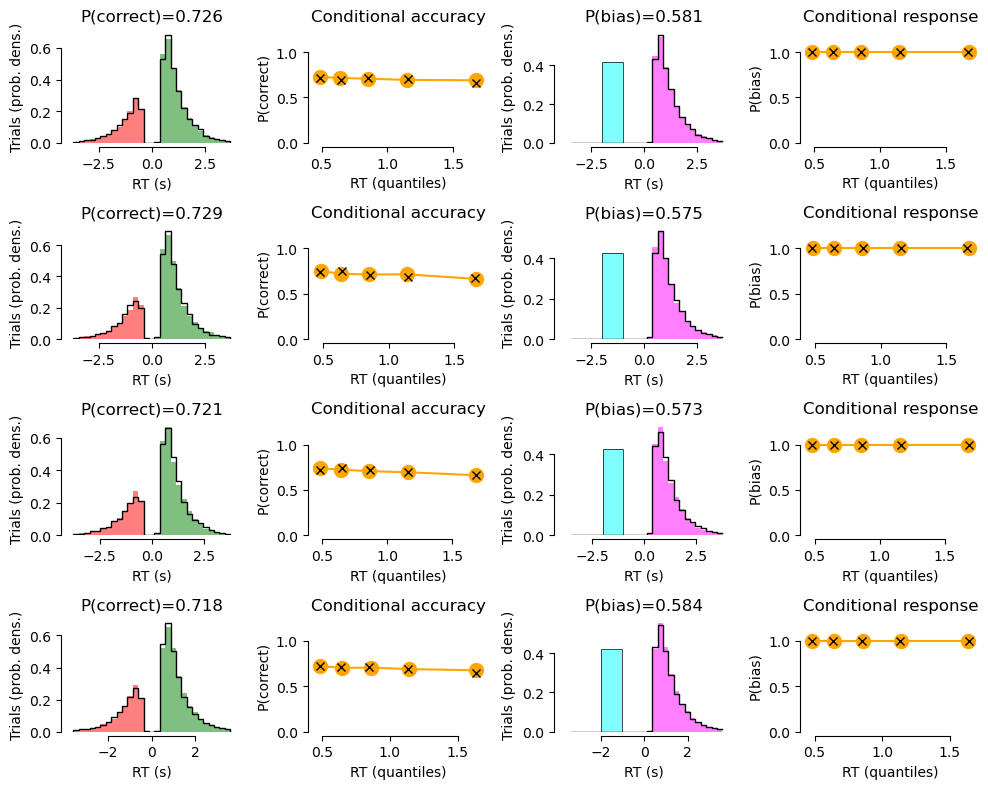

In [20]:
# Plot data with model fit on top:
for c in np.unique(df_emp["condition"]):
    print("CONDITION {}".format(c))
    summary_plot(
        df_group=df_emp.loc[(df_emp["condition"] == c), :],
        df_sim_group=df_sim.loc[(df_emp["condition"] == c), :],
    )
    plt.show()